In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import scipy as sc

from aemulus_heft.heft_emu import HEFTEmulator
from aemulus_heft.utils import lpt_spectra

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.size']             = 12

This notebook compares the measured and best-fit HEFT spectra to a) 13 AbacusSummit base boxes and b) a single $w_0w_a$ CDM+$m_{\nu}$ simulation.

In [ ]:
# setting up HEFT emulator
emu = HEFTEmulator()
z=0.5
# (ombh2, omch2, w0, ns, 10^9 As, H0, mnu)
cosmo = [0.0223, 0.12, -1, 0.96, 2.1, 67, 0.06]
k = np.logspace(-3, 0, 100)
spec_lpt, sigma8z = lpt_spectra(k, z, cosmo)
cosmo.append(sigma8z)
spec_heft = emu.predict(k, np.array(cosmo), spec_lpt)


In [ ]:
# loading in average measured pgg and pgm from Abacus simulations
kk, pk_gg_avg = np.loadtxt('abacus_spectra/pk_gg_abacus_avg.txt', unpack=True)
kk, pk_gm_avg = np.loadtxt('abacus_spectra/pk_gm_abacus_avg.txt', unpack=True)

In [4]:
def bias_fit_abacus(biases):

    # idx_max = 93 # kmax=~0.3
    idx_max = 192 #kmax~=0.6
    
    phh_dat = pk_gg_avg
    phm_dat = pk_gm_avg
    
    phh_fit = emu.basis_to_full(k, biases, spec_heft, cross=False)
    phh_fit_interp = sc.interpolate.interp1d(k, phh_fit)
    phm_fit = emu.basis_to_full(k, biases, spec_heft, cross=True)
    phm_fit_interp = sc.interpolate.interp1d(k, phm_fit)

    chisq = np.sum((phh_dat[:idx_max]-phh_fit_interp(kk[:idx_max]))**2/(phh_fit_interp(kk[:idx_max]))) + \
            np.sum((phm_dat[:idx_max]-phm_fit_interp(kk[:idx_max]))**2/(phm_fit_interp(kk[:idx_max]))) + \
            0.1*np.sum((phh_dat[idx_max:]-phh_fit_interp(kk[idx_max:]))**2/(phh_fit_interp(kk[idx_max:]))) + \
            0.1*np.sum((phm_dat[idx_max:]-phm_fit_interp(kk[idx_max:]))**2/(phm_fit_interp(kk[idx_max:])))
    
    return chisq


In [5]:
abacus_fit_2 = sc.optimize.minimize(bias_fit_abacus, x0=[1.5,-2,1.0,-2,1e3])
fit_2 = abacus_fit_2['x']

P_gg = emu.basis_to_full(k, fit_2, spec_heft, cross=False)
P_gg_interp = sc.interpolate.interp1d(k, P_gg)

P_gm = emu.basis_to_full(k, fit_2, spec_heft, cross=True)
P_gm_interp = sc.interpolate.interp1d(k, P_gm)

print(fit_2)

[ 4.38303266e-01  1.70508976e-02 -2.68243444e-01 -2.93614585e-02
  7.69259905e+01]


### Aemulus ###

In [ ]:
# loading in HEFT component spectra
heft_spectra = np.load('aemulus_data/basis_spectra_nbody_pk_rsd=False_pypower=True_a0.6504_nmesh1400.npy', allow_pickle=True)
k = heft_spectra[0]['k'][:349]

# loading in measured pgg and pgm
pgg_aem = np.load('aemulus_data/p_gg_w0wa.npy')[:349].real
pgm_aem = np.load('aemulus_data/p_gm_w0wa.npy')[:349].real

# loading in fits
pgg_aem_fit = np.loadtxt('aemulus_data/quadfit_auto.txt', unpack=True)[1]
pgm_aem_fit = np.loadtxt('aemulus_data/quadfit_cross.txt', unpack=True)[1]

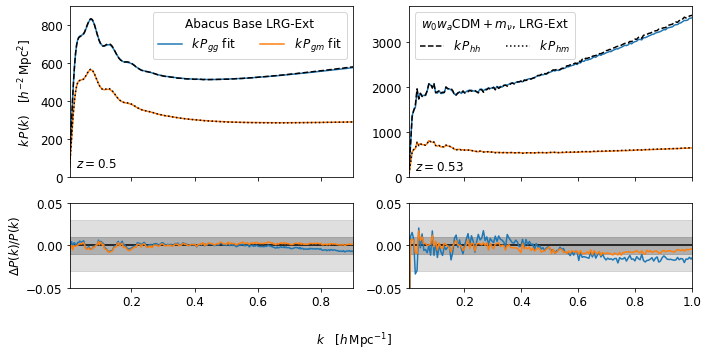

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10,5), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

axs[1][0].axhline(0, c='k')
axs[1][0].fill_between(kk, -0.03, 0.03, color='gray', alpha=0.25)
axs[1][0].fill_between(kk, -0.01, 0.01, color='gray', alpha=0.5)

# abacus
axs[0][0].plot(kk, kk*P_gg_interp(kk), label=r'$k\,P_{gg}$ fit')
axs[0][0].plot(kk, kk*P_gm_interp(kk), label=r'$k\,P_{gm}$ fit')

axs[0][0].plot(kk, kk*pk_gg_avg, color='k', ls='--')
axs[0][0].plot(kk, kk*pk_gm_avg, color='k', ls=':')

axs[0][0].set_ylabel(r'$k\,P(k)\quad[h^{-2}\,{\rm Mpc}^{2}]$')
axs[0][0].legend(title='Abacus Base LRG-Ext', ncol=3)

axs[0][0].set_ylim(0, 900)
axs[0][1].set_ylim(0, 3800)

axs[0][0].text(0.025,50,r'$z=0.5$')
axs[0][1].text(0.025,150,r'$z=0.53$')

axs[1][0].plot(kk, (P_gg_interp(kk)-pk_gg_avg)/pk_gg_avg)
axs[1][0].plot(kk, (P_gm_interp(kk)-pk_gm_avg)/pk_gm_avg)

axs[1][0].set_ylim(-0.05, 0.05)

axs[1][0].set_ylabel(r'$\Delta P(k)/P(k)$')

# aemulus
axs[0][0].set_xlim(min(k), 0.9)
axs[0][1].set_xlim(min(k), 1)

axs[0][1].plot(k, k*pgg_aem_fit)
axs[0][1].plot(k, k*pgm_aem_fit)

axs[0][1].plot(k, k*pgg_aem, ls='--', color='k', label=r'$k\,P_{hh}$')#, c='C0')
axs[0][1].plot(k, k*pgm_aem, ls=':', color='k', label=r'$k\,P_{hm}$')#, c='C1')

axs[0][1].legend(title=r'$w_0w_a{\rm CDM}+m_{\nu}$, LRG-Ext', ncol=2)

axs[1][1].axhline(0, c='k')
axs[1][1].fill_between(k, -0.03, 0.03, color='gray', alpha=0.25)
axs[1][1].fill_between(k, -0.01, 0.01, color='gray', alpha=0.5)

axs[1][1].set_ylim(-0.05, 0.05)

axs[1][1].plot(k, (pgg_aem_fit-pgg_aem)/pgg_aem)
axs[1][1].plot(k, (pgm_aem_fit-pgm_aem)/pgm_aem)

fig.supxlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$', fontsize=12)

fig.tight_layout()
fig.savefig('figures/HEFT_validation.pdf')
